In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

## running the model

In [3]:
from gaze import init
args = init(verbose=0)
print('Parameters=', args)

path = '_Regard.pt'

Parameters= {'batch_size': 16, 'test_batch_size': 1, 'valid_size': 0.2, 'epochs': 40, 'do_adam': False, 'lr': 0.05, 'momentum': 0.18, 'no_cuda': False, 'num_processes': 1, 'seed': 42, 'log_interval': 10, 'fullsize': 175, 'crop': 175, 'size': 150, 'mean': 0.36, 'std': 0.3, 'conv1_dim': 5, 'conv1_kernel_size': 7, 'conv2_dim': 13, 'conv2_kernel_size': 7, 'stride1': 2, 'stride2': 4, 'N_cv': 10, 'dimension': 25, 'verbose': 0}


In [4]:
!ls -l {path}
#!rm {path}

ls: _Regard.pt: No such file or directory
rm: _Regard.pt: No such file or directory


In [5]:
from gaze import ML
ml = ML(args)

import os
import torch
if os.path.isfile(path):
    ml.model.load_state_dict(torch.load(path))
    print('Loading file', path)
else:
    print('Training model...')
    ml.train()
    torch.save(ml.model.state_dict(), path) #save the neural network state
    print('Model saved at', path)

Training model...
Model saved at _Regard.pt


## testing the model

In [6]:
Accuracy = ml.test()


Test set: Average loss: 0.2972, Accuracy: 45/46 (97%)



target:right
pred  : left


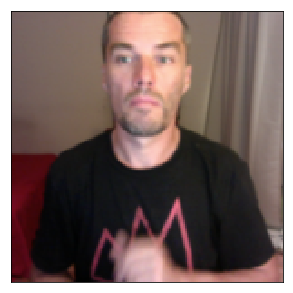

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

for data, labels in ml.dataset.test_loader:
    fig, ax = ml.show(only_wrong=True)
    plt.show() 


## cross-validation

In [ ]:
Accuracy = []
for _ in range(30):
    args = init(verbose=0, log_interval=0, seed=42+_)
    ml = ML(args)
    ml.main()
    Accuracy.append(ml.test())
print(Accuracy)

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(Accuracy, bins=7) 

plt.show() 